In [8]:
# %pip install transformers

In [9]:
from transformers import BertTokenizer
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import cv2

In [10]:
# %pip install pyspedas

In [11]:
# %pip install --upgrade setuptools

In [12]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from bert_.modeling_bert import BertModel
from bert_.tokenization_bert import BertTokenizer
from lib import segmentation

In [13]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load reference texts
reference_texts = {}
with open('reference.txt', 'r') as f:
    for line in f:
        img, desc = line.strip().split(' : ')
        reference_texts[img] = desc.strip('"')

class Args:
    def __init__(self):
        self.swin_type = 'base'
        self.window12 = True
        self.mha = ''
        self.fusion_drop = 0.0
        self.num_features = 0  # This was missing and is required
    
# Image preprocessing
def preprocess_image(image_path, img_size=480):
    transform = T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor.to(device), img

# Model initialization
def initialize_model(weights_path):
    args_ = Args()  # Create an instance of Args
    model = segmentation.lavt(pretrained='', args=args_)  # Use public API instead of nonexistent _dict
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.pooler = None
    
    checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)
    bert_model.load_state_dict(checkpoint['bert_model'])
    model.load_state_dict(checkpoint['model'])
    
    return model.to(device), bert_model.to(device)

# Text preprocessing
def process_text(text, tokenizer):
    inputs = tokenizer(text, padding='longest', return_tensors="pt")
    return inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

def visualize_results(image, mask, text, title_prefix="Success"):
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Segmentation mask
    plt.subplot(132)
    mask_np = mask.cpu().numpy().squeeze()
    plt.imshow(mask_np, cmap='jet', alpha=0.7)
    plt.title(f'{title_prefix} Segmentation\n"{text}"')
    plt.axis('off')
    
def visualize_y1_features(model, image_tensor, tokens):
    with torch.no_grad():
        # Get Y1 features from the model
        y1_features = model.get_intermediate_features()
        
        # Normalize and convert to heatmap
        y1_features = F.interpolate(y1_features, size=(480, 480), 
                                  mode='bilinear', align_corners=False)
        y1_features = y1_features.mean(dim=1)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(y1_features[0].cpu(), cmap='hot')
        plt.title('Y1 Feature Map')
        plt.colorbar()
        plt.axis('off')
        plt.show()

# Main processing function
def process_samples(model, bert_model, tokenizer, img_name, ref_text):
    img_path = os.path.join('Images', img_name)
    img_tensor, orig_img = preprocess_image(img_path)
    
    input_ids, attention_mask = process_text(ref_text, tokenizer)
    
    with torch.no_grad():
        last_hidden_states = bert_model(input_ids, attention_mask=attention_mask)[0]
        embedding = last_hidden_states.permute(0, 2, 1)
        
        output = model(img_tensor, embedding, l_mask=attention_mask.unsqueeze(-1))
        pred_mask = output.argmax(1, keepdim=True)
        
        visualize_results(orig_img, pred_mask, ref_text)
        visualize_y1_features(model, img_tensor, input_ids)
        

In [14]:
model, bert_model = initialize_model('checkpoints/refcoco.pth')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Window size 12!
Randomly initialize Multi-modal Swin Transformer weights.
Randomly initialize Multi-modal Swin Transformer weights.


Downloading: 100%|██████████| 232k/232k [00:00<00:00, 292kB/s]  



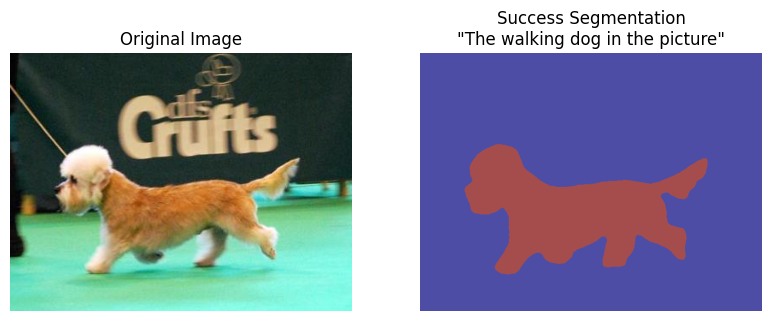

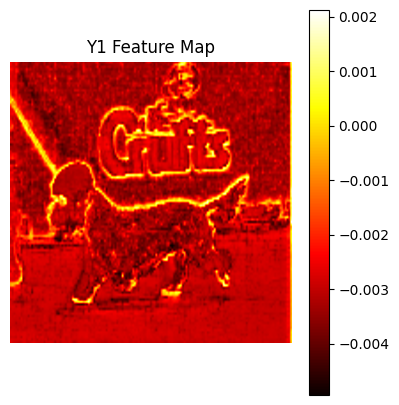

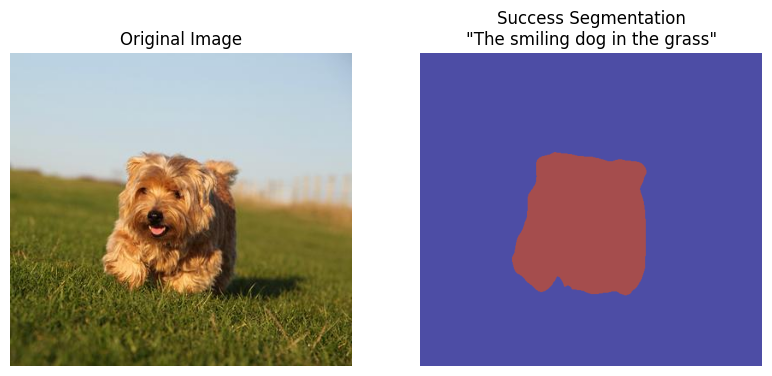

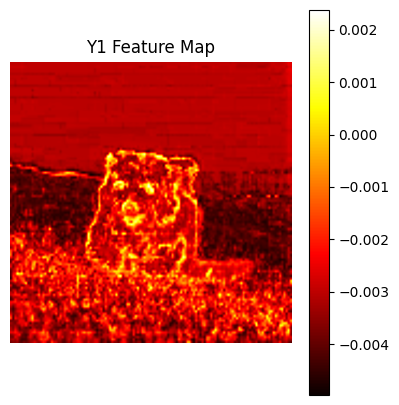

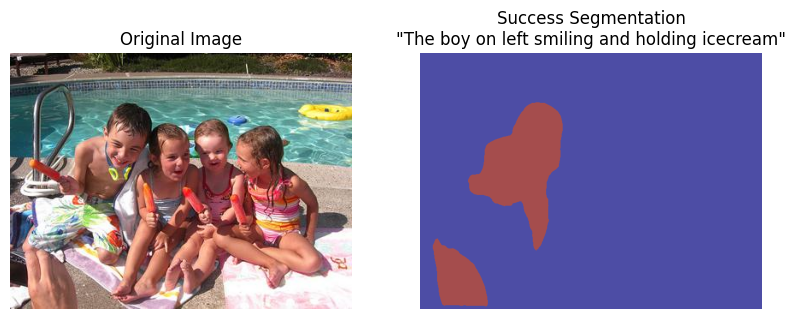

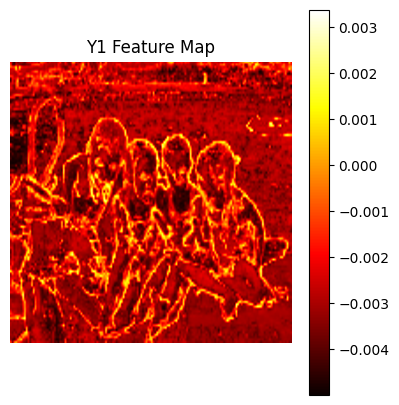

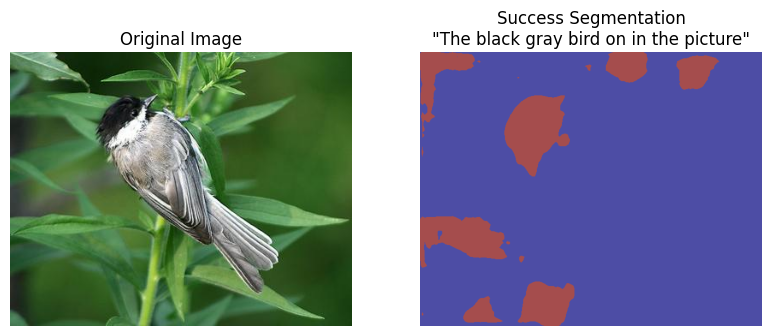

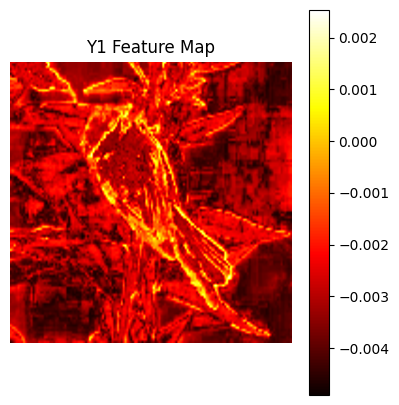

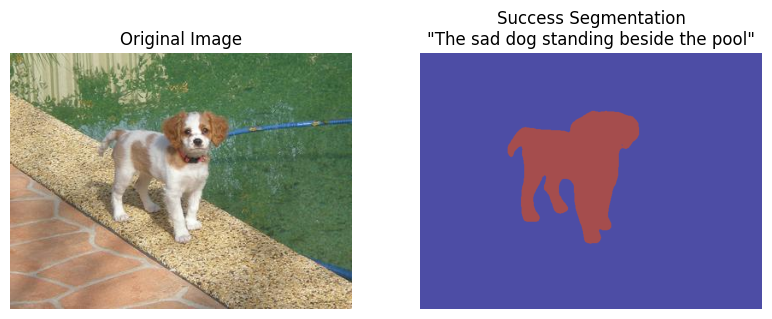

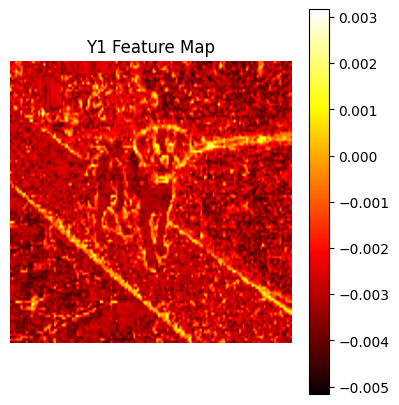

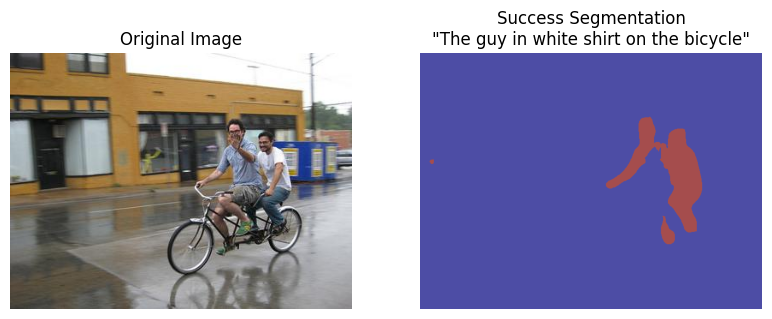

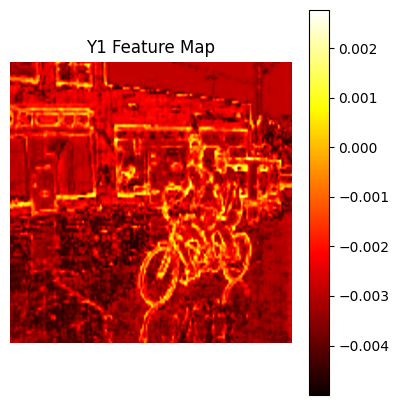

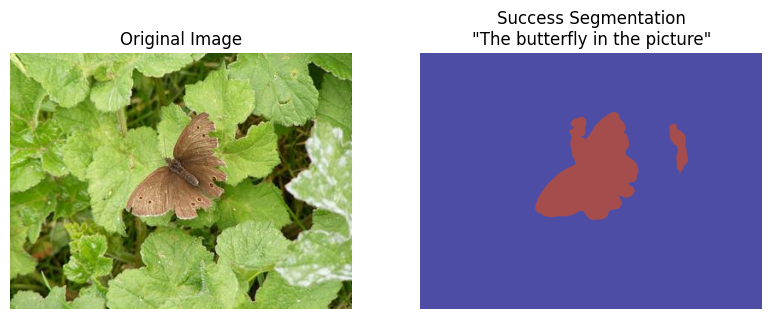

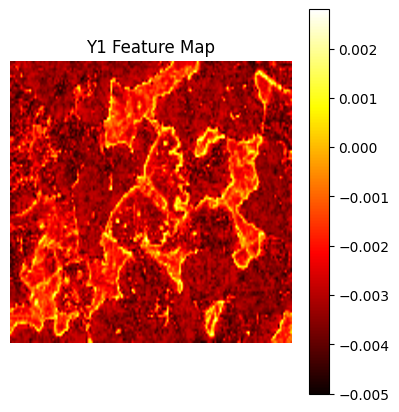

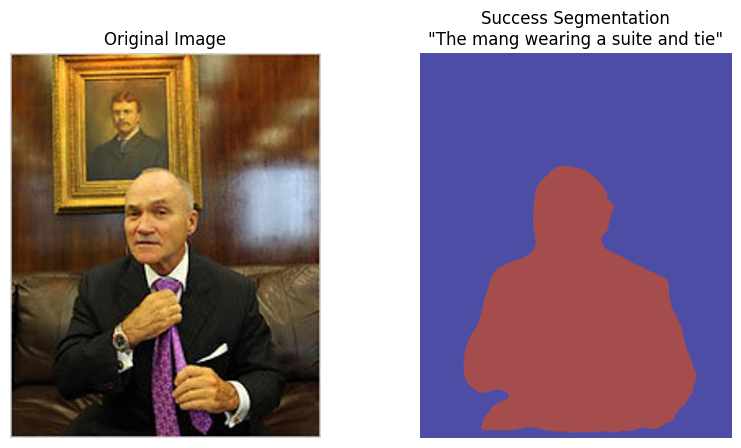

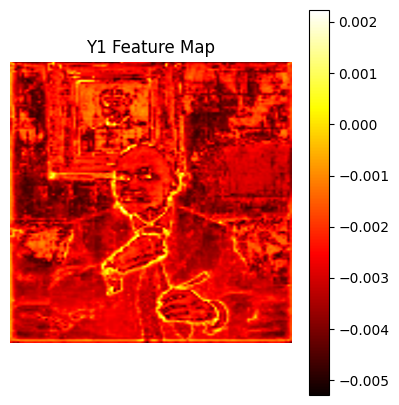

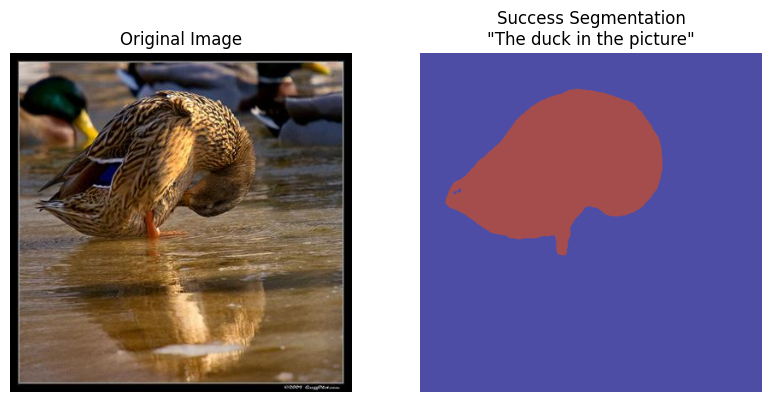

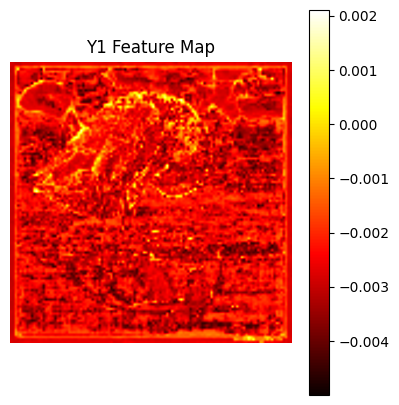

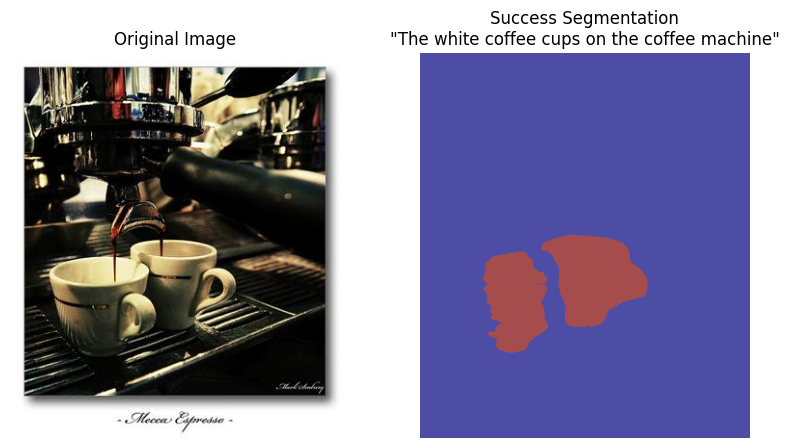

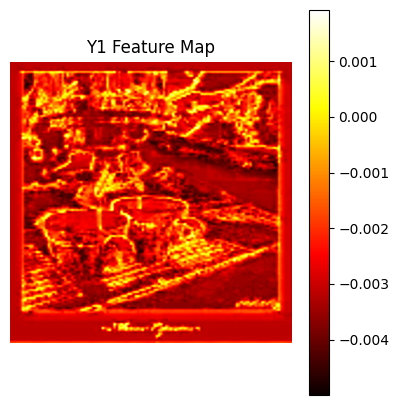

In [15]:
for img_name, desc in reference_texts.items():
    process_samples(model, bert_model, tokenizer, img_name, desc)